# LSTM recipe generator training

Note: This notebook is desinged to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer and the recipe dataset.

**You can igore the error message like `ERROR: pip's dependency resolver does not currently take into account...`.**

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatibl

Import modules and set random seeds.

In [2]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20230629)

import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [3]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print('Vocabulary size: {}'.format(VOCAB_SIZE))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Vocabulary size: 30522


Download the recipe dataset and extract directions texts.

In [4]:
from datasets import load_dataset
recipe = load_dataset('Shengtao/recipe')

def join_title_and_directions(title_directions):
    title, directions = title_directions
    return 'Recipe for {}: {}'.format(title, directions)

recipe_texts = list(map(join_title_and_directions,
                        zip(recipe['train']['title'], recipe['train']['directions'])))
recipe_texts = recipe_texts[::4] # Select 25% of the entire training set.

Generating train split:   0%|          | 0/32722 [00:00<?, ? examples/s]

In [5]:
recipe_texts[0]

'Recipe for Simple Macaroni and Cheese: Bring a large pot of lightly salted water to a boil. Cook elbow macaroni in the boiling water, stirring occasionally until cooked through but firm to the bite, 8 minutes. Drain. Melt butter in a saucepan over medium heat; stir in flour, salt, and pepper until smooth, about 5 minutes. Slowly pour milk into butter-flour mixture while continuously stirring until mixture is smooth and bubbling, about 5 minutes. Add Cheddar cheese to milk mixture and stir until cheese is melted, 2 to 4 minutes. Fold macaroni into cheese sauce until coated.'

Check the distribuion of the text length.

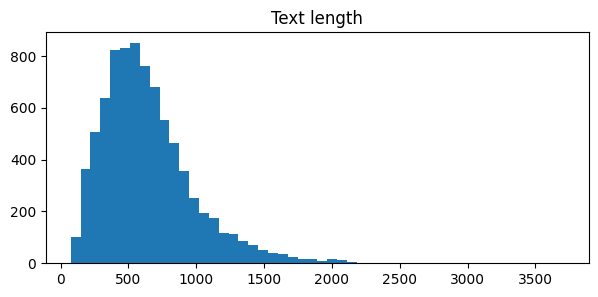

In [6]:
fig = plt.figure(figsize=(7, 3))
subplot = fig.add_subplot(1,1,1)
subplot.set_title('Text length')
_ = subplot.hist(list(map(lambda x: len(x), recipe_texts)), bins=50)

Create the training and test datasets, truncating long texts into 512 words.

In [7]:
MAX_LEN = 512

train_set, test_set = train_test_split(recipe_texts, test_size=0.1)

train_set = tokenizer(train_set, max_length=MAX_LEN,
                      padding='max_length', truncation=True)
train_text = np.array(train_set['input_ids'])[:, :-1]
train_label = np.array(train_set['input_ids'])[:, 1:]

test_set = tokenizer(test_set, max_length=MAX_LEN,
                     padding='max_length', truncation=True)
test_text = np.array(test_set['input_ids'])[:, :-1]
test_label = np.array(test_set['input_ids'])[:, 1:]

Define the LSTM model.

In [8]:
lstm_model = models.Sequential(name='LSTM_next_word_predictor')
lstm_model.add(layers.Embedding(VOCAB_SIZE, 512, input_shape=(None,), name='text_embedding'))
lstm_model.add(layers.LSTM(512, return_sequences=True, name='LSTM_cell'))
lstm_model.add(layers.Dense(VOCAB_SIZE, activation='softmax', name='softmax'))

lstm_model.summary()

Model: "LSTM_next_word_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_embedding (Embedding)  (None, None, 512)         15627264  
                                                                 
 LSTM_cell (LSTM)            (None, None, 512)         2099200   
                                                                 
 softmax (Dense)             (None, None, 30522)       15657786  
                                                                 
Total params: 33384250 (127.35 MB)
Trainable params: 33384250 (127.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile the model using the Adam optimizer, and the sparse categorical crossentroy as a loss function.

In [9]:
lstm_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['acc'])

Train the model.

In [10]:
%%time
history = lstm_model.fit(train_text, train_label,
                         validation_data=(test_text, test_label),
                         batch_size=8, epochs=5)

Epoch 1/5
921/921 [==============================] - 267s 285ms/step - loss: 1.5493 - acc: 0.7629 - val_loss: 0.9398 - val_acc: 0.8233
Epoch 2/5
921/921 [==============================] - 234s 254ms/step - loss: 0.8189 - acc: 0.8394 - val_loss: 0.7609 - val_acc: 0.8469
Epoch 3/5
921/921 [==============================] - 240s 261ms/step - loss: 0.7011 - acc: 0.8542 - val_loss: 0.6988 - val_acc: 0.8550
Epoch 4/5
921/921 [==============================] - 240s 261ms/step - loss: 0.6446 - acc: 0.8612 - val_loss: 0.6669 - val_acc: 0.8594
Epoch 5/5
921/921 [==============================] - 240s 261ms/step - loss: 0.6066 - acc: 0.8662 - val_loss: 0.6480 - val_acc: 0.8625
CPU times: user 7min 28s, sys: 3min 14s, total: 10min 42s
Wall time: 20min 21s


Mount the google drive and save the trained model.

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

lstm_model.save('/content/gdrive/My Drive/LSTM_recipe_generator.hd5', save_format='h5')

Mounted at /content/gdrive


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
ls -lh '/content/gdrive/My Drive/LSTM_recipe_generator.hd5'

-rw------- 1 root root 383M Jun 17 06:23 '/content/gdrive/My Drive/LSTM_recipe_generator.hd5'
